In [1]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("uciml/sms-spam-collection-dataset")

print("Path to dataset files:", path)

100%|██████████| 211k/211k [00:00<00:00, 218kB/s]

Extracting files...
Path to dataset files: C:\Users\debas\.cache\kagglehub\datasets\uciml\sms-spam-collection-dataset\versions\1


In [3]:
#Loading the dataset
import os
file_path = os.path.join(path,'spam.csv')
df= pd.read_csv(file_path,encoding='latin-1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.columns.tolist()

['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

In [5]:
#Dropping unnecessary cols from the df
df= df[['v1', 'v2']]
df.columns = ['Label','Message']

In [6]:
df.head()

,Label,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
#preprocessing dataset
import re
import string

#converting labels to binary
df['Label'] = df['Label'].map({'ham':0,'spam':1})



In [10]:
#Text cleaning
def cleaning_text(text):
    text = text.lower()
    text = re.sub(r'\d+','',text)
    text = text.translate(str.maketrans('','',string.punctuation))
    text = re.sub(r'\s+',' ',text).strip()
    return text

df['Message'] = df['Message'].apply(cleaning_text)

In [11]:
df.head()

,Label,Message
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final ...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


In [14]:
#Splitting data and vectorizing using TF-IDF

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['Message']
y = df['Label']

tfidf = TfidfVectorizer(stop_words='english',max_features=5000)
X = tfidf.fit_transform(X)

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
X_train.shape

(4457, 5000)

In [17]:
X_test.shape

(1115, 5000)

In [18]:
#Training the models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

nb = MultinomialNB()
lr = LogisticRegression(max_iter=1000)
svm = SVC(kernel='linear')

In [19]:
nb.fit(X_train,y_train)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [20]:
lr.fit(X_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [21]:
svm.fit(X_train,y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [22]:
#Predicting models
y_pred_nb = nb.predict(X_test)
y_pred_lr = lr.predict(X_test)
y_pred_svm = svm.predict(X_test)

In [23]:
#Evaluting the scores
from sklearn.metrics import accuracy_score,f1_score,classification_report

def evaluate_score(name,y_true,y_pred):
    print(f"{name} Evaluation...\n")
    print(f"Accuracy: {accuracy_score(y_true,y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true,y_pred,average='weighted'):.4f}")
    print(f"Classification Report: {classification_report(y_true,y_pred)}")

In [24]:
evaluate_score('Logistic Regression',y_test,y_pred_lr)

Logistic Regression Evaluation...

Accuracy: 0.9489
F1 Score: 0.9443
Classification Report:               precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.97      0.64      0.77       150

    accuracy                           0.95      1115
   macro avg       0.96      0.82      0.87      1115
weighted avg       0.95      0.95      0.94      1115



In [25]:
evaluate_score('Naive Bayes',y_test,y_pred_nb)

Naive Bayes Evaluation...

Accuracy: 0.9713
F1 Score: 0.9698
Classification Report:               precision    recall  f1-score   support

           0       0.97      1.00      0.98       965
           1       1.00      0.79      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [26]:
evaluate_score('SVM',y_test,y_pred_svm)

SVM Evaluation...

Accuracy: 0.9785
F1 Score: 0.9778
Classification Report:               precision    recall  f1-score   support

           0       0.98      1.00      0.99       965
           1       0.98      0.85      0.91       150

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



In [27]:
#sample test on model
def predict_message(model,msg):
    msg = cleaning_text(msg)
    vec = tfidf.transform([msg])
    pred = model.predict(vec)[0]
    return 'Spam' if pred == 1 else 'Ham'



In [28]:
print(predict_message(svm,"Congratulations! You've won a jackpot worth $1B !!!!!"))


Spam


In [29]:
print(predict_message(svm,'Hey,How are you?'))

Ham


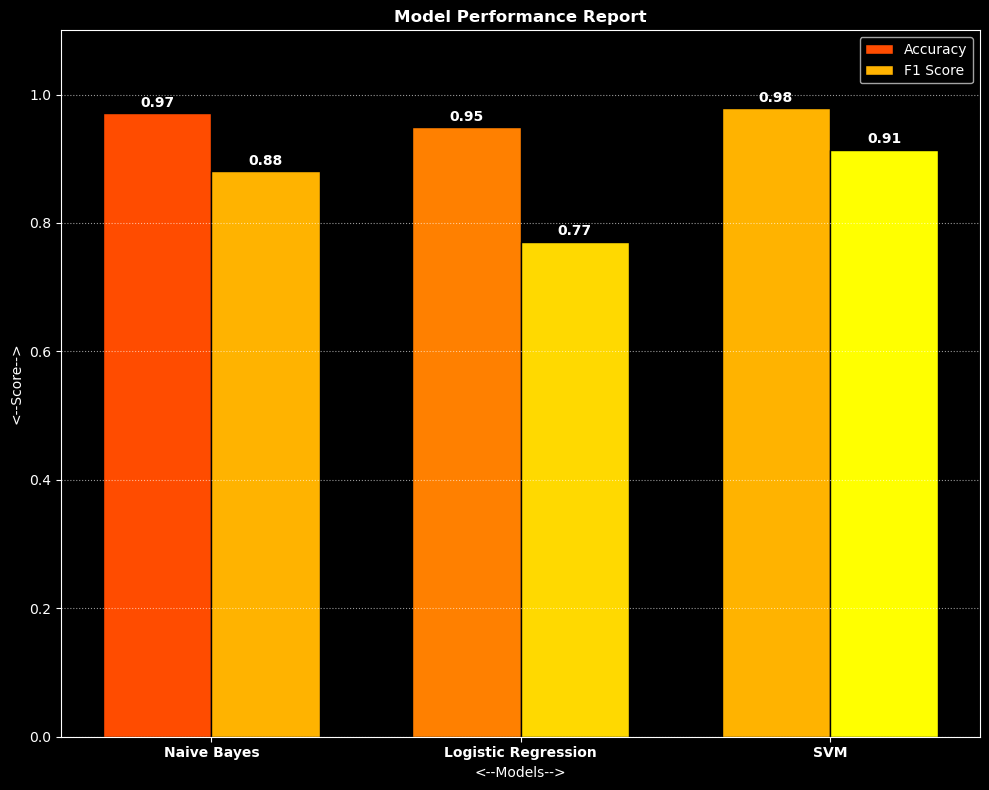

In [36]:
#Model comparison plot

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

models = ['Naive Bayes','Logistic Regression','SVM']

accuracy = [
    accuracy_score(y_test,y_pred_nb),
    accuracy_score(y_test,y_pred_lr),
    accuracy_score(y_test,y_pred_svm)
]
f1_scores =[
    f1_score(y_test,y_pred_nb),
    f1_score(y_test,y_pred_lr),
    f1_score(y_test,y_pred_svm)
]

#Defining colors
colors_acc = cm.autumn(np.linspace(0.3,0.7,len(models)))
colors_f1 = cm.autumn(np.linspace(0.7,1.0,len(models)))

#plot settings
x= np.arange(len(models))
width = 0.35

plt.figure(figsize = (10,8))
plt.bar(x-width/2, accuracy, width=width,color=colors_acc,edgecolor='black',label='Accuracy')
plt.bar(x+width/2,f1_scores, width=width,color=colors_f1,edgecolor='black',label='F1 Score')

plt.style.use('dark_background')
# Annotations
for i in range(len(models)):
    plt.text(x[i] - width/2, accuracy[i] + 0.01, f"{accuracy[i]:.2f}", ha='center', fontsize=10, fontweight='bold')
    plt.text(x[i] + width/2, f1_scores[i] + 0.01, f"{f1_scores[i]:.2f}", ha='center', fontsize=10, fontweight='bold')

plt.xticks(x,models,fontsize=10,fontweight='bold')
plt.xlabel('<--Models-->',fontsize=10)
plt.ylabel('<--Score-->',fontsize=10)
plt.title('Model Performance Report',fontsize=12,fontweight='bold')
plt.ylim(0,1.1)
plt.legend(frameon=True,fontsize=10)
plt.grid(axis='y',linestyle='dotted',alpha=0.6)
plt.tight_layout()
plt.show()


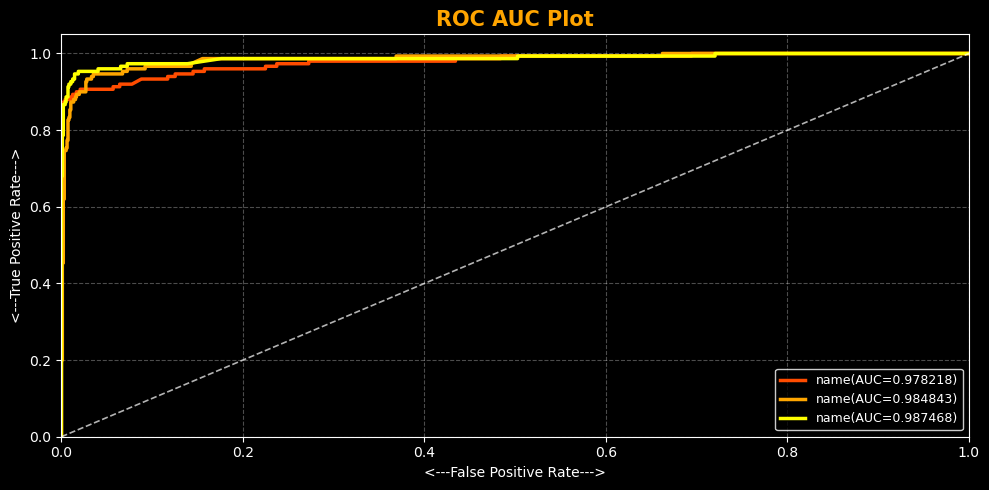

In [46]:
#ROC AUC plot for each model
from sklearn.metrics import roc_curve,auc

models_ = {
    'Naive Bayes':nb,
    'Logistic Regression':lr,
    'SVM':svm
}

colors = cm.autumn(np.linspace(0.3,1.0,len(models_)))
plt.style.use('dark_background')

plt.figure(figsize = (10,5))

for (name,model), colors in zip(models_.items(),colors):
    if hasattr(model,'predict_proba'):
        y_score = model.predict_proba(X_test)[:,1]
    else:
        y_score = model.decision_function(X_test)

    fpr,tpr,_ = roc_curve(y_test,y_score)
    roc_auc = auc(fpr,tpr)

    plt.plot(fpr,tpr,color=colors,lw=2.5,label=f"name(AUC={roc_auc:3f})")

#reference line
plt.plot([0,1],[0,1],color='white',linestyle='--',lw=1.2,alpha=0.7)

plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('<---False Positive Rate--->',fontsize=10)
plt.ylabel('<---True Positive Rate--->',fontsize=10)
plt.title('ROC AUC Plot',fontsize=15,fontweight='bold',color='orange')
plt.legend(loc="lower right",frameon=True,fontsize=9,facecolor='black',edgecolor='white')
plt.grid(alpha=0.3,linestyle='--')
plt.tight_layout()
plt.show()


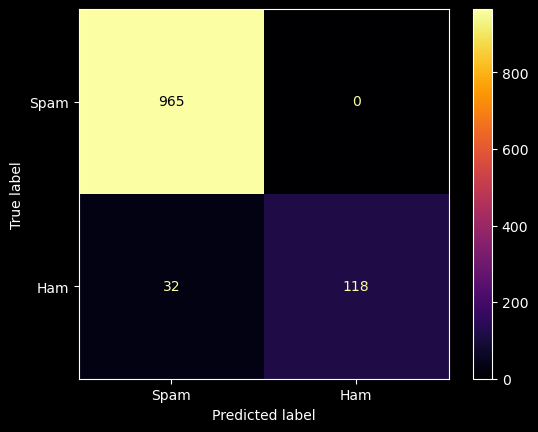

In [50]:
#Confusion matrix for the best model: svm
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test,y_pred_nb)
disp = ConfusionMatrixDisplay(cm ,display_labels=['Spam','Ham'])
disp.plot(cmap='inferno')